# Capacitance Matrix and LOM Analysis

## Prerequisite
You must have a working local installation of Ansys.

## 1. Create the design in Metal

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

In [3]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

In [4]:
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

### In this example, the design consists of 4 qubits and 4 CPWs

In [5]:
# Allow running the same cell here multiple times to overwrite changes
design.overwrite_enabled = True

## Custom options for all the transmons
options = dict(
    # Some options we want to modify from the defaults
    # (see below for defaults)
    pad_width = '425 um', 
    pocket_height = '650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        bus1 = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        bus2 = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

## Create 4 transmons

q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.42251mm', pos_y='+0.0mm', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.95mm', orientation = '270', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.42251mm', pos_y='+0.0mm', orientation = '180', **options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.95mm', orientation = '90', **options))

RouteMeander.get_template_options(design)

options = Dict(
        lead=Dict(
            start_straight='0.2mm',
            end_straight='0.2mm'),
        trace_gap='9um',
        trace_width='15um')

def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='90um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        hfss_wire_bonds = True,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)

asym = 140
cpw1 = connect('cpw1', 'Q1', 'bus2', 'Q2', 'bus1', '6.0 mm', f'+{asym}um')
cpw2 = connect('cpw2', 'Q3', 'bus1', 'Q2', 'bus2', '6.1 mm', f'-{asym}um', flip=True)
cpw3 = connect('cpw3', 'Q3', 'bus2', 'Q4', 'bus1', '6.0 mm', f'+{asym}um')
cpw4 = connect('cpw4', 'Q1', 'bus1', 'Q4', 'bus2', '6.1 mm', f'-{asym}um', flip=True)

gui.rebuild()
gui.autoscale()

## 2. Render into Ansys Q3D

In [6]:
fourq_q3d = design.renderers.q3d

Skip the next cell if Ansys is already open and with a project loaded.

In [7]:
fourq_q3d.open_ansys()

**Wait for Ansys to open up completely before proceeding to the next cell.**<br>
If necessary, also close any Ansys popup windows.
If no project is currently open, one can be added via the below cell.

In [8]:
#fourq_q3d.new_ansys_project()

In [9]:
fourq_q3d.connect_ansys()
fourq_q3d.add_q3d_design("Q3dMetalDesign")

INFO 01:56PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:56PM [load_ansys_project]: 	Opened Ansys App
INFO 01:56PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 01:56PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project1
INFO 01:56PM [connect_design]: No active design found (or error getting active design).
INFO 01:56PM [connect]: 	 Connected to project "Project1". No design detected
INFO 01:56PM [connect_design]: 	Opened active design
	Design:    Q3dMetalDesign [Solution type: Q3D]
WARNING 01:56PM [connect_setup]: 	No design setup detected.
WARNING 01:56PM [connect_setup]: 	Creating Q3D default setup.
INFO 01:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


Render a single qubit with 2 endcaps

In [10]:
fourq_q3d.render_design(['Q1'], [('Q1', 'readout'), ('Q1', 'bus1'), ('Q1', 'bus2')])

## 3. Create a new solution setup in Ansys Q3D and obtain the capacitance matrix

In [11]:
#     Add a solution setup:
fourq_q3d.add_q3d_setup()
#     Example of how to change defaults (just an example. We will not use this setup):
# fourq_q3d.add_q3d_setup(name = 'Setup2', max_passes = 20)

Optional keyword parameters and their defaults, listed below, represent parameters in this Q3D solution setup. Running fourq_q3d.add_q3d_setup() is equivalent to going to the Project Manager panel in Ansys, right clicking on Analysis within the active Q3D design, selecting "Add Solution Setup...", and choosing/entering default values in the resulting popup window. To easily keep track of different solution setups, give each of them a different name, otherwise, Ansys will simply append numbers to the end of duplicate names. <br><br>
freq_ghz: float = 5. <br>
name: str = "Setup" <br>
save_fields: bool = False <br>
enabled: bool = True <br>
max_passes: int = 15 <br>
min_passes: int = 2 <br>
min_converged_passes: int = 2 <br>
percent_error: float = 0.5 <br>
percent_refinement: int = 30 <br>
auto_increase_solution_order: bool = True <br>
solution_order: str = 'High' <br>
solver_type: str = 'Iterative <br><br>
These defaults can be modified by including the keywords and their new values inside the parentheses. For example, to increase the maximum number of passes from the default value of 15 up to 20 while leaving all else unchanged, replace the cell above with the following: <br><br>
fourq_q3d.add_q3d_setup(max_passes = 20)

In [12]:
# Analyze said solution setup.
fourq_q3d.analyze_setup("Setup")

INFO 01:57PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:57PM [analyze]: Analyzing setup Setup


In [13]:
# Using the analysis results, get its capacitance matrix as a dataframe.
fourq_q3d.get_capacitance_matrix()

INFO 01:58PM [get_matrix]: Exporting matrix data to (C:\AppData\Local\Temp\tmptme20c8o.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False


,bus1_connector_pad_Q1,bus2_connector_pad_Q1,ground_main_plane,pad_bot_Q1,pad_top_Q1,readout_connector_pad_Q1
bus1_connector_pad_Q1,50.59475,-0.42373,-34.00537,-1.54779,-13.49320,-0.20664
bus2_connector_pad_Q1,-0.42373,54.94375,-36.29163,-14.31897,-1.83808,-1.03145
ground_main_plane,-34.00537,-36.29163,237.02640,-31.52366,-38.22709,-37.11942
pad_bot_Q1,-1.54779,-14.31897,-31.52366,99.53492,-30.61516,-19.21035
pad_top_Q1,-13.49320,-1.83808,-38.22709,-30.61516,89.15073,-2.22435
readout_connector_pad_Q1,-0.20664,-1.03145,-37.11942,-19.21035,-2.22435,60.91761


The optional keyword parameters of get_capacitance_matrix are given below: <br><br>
variation: str = '' <br>
solution_kind: str = 'LastAdaptive' <br>
pass_number: int = 3

In [14]:
# Run lumped oscillator model (LOM) simulations and save results in dict_lom.b
dict_lom = fourq_q3d.lumped_oscillator_vs_passes(12.31, 2, 3, 7.0, [6.0, 6.2], 9)
dict_lom

INFO 01:58PM [get_matrix]: Exporting matrix data to (C:\AppData\Local\Temp\tmpwx38c_vz.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 01:58PM [get_matrix]: Exporting matrix data to (C:\AppData\Local\Temp\tmpnd11dx2d.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 01:58PM [get_matrix]: Exporting matrix data to (C:\AppData\Local\Temp\tmpc_7dob0s.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 01:58PM [get_matrix]: Exporting matrix data to (C:\AppData\Local\Temp\tmp0ocfdbfn.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 4, False
INFO 01:58PM [get_matrix]: Exporting matrix data to (C:\AppData\Local\Temp\tmplxo2w0f1.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 5, False
INFO 01:58PM [get_matrix]: Exporting matrix data to (C:\AppData\Local\

[3, 4] [5 0 1]
Predicted Values

Transmon Properties
f_Q 5.389238 [GHz]
EC 307.600806 [MHz]
EJ 13.273404 [GHz]
alpha -358.183525 [MHz]
dispersion 41.048534 [KHz]
Lq 12.305036 [nH]
Cq 62.971968 [fF]
T1 37.188847 [us]

**Coupling Properties**

tCqbus1 7.545643 [fF]
gbus1_in_MHz 115.474739 [MHz]
χ_bus1 -3.076012 [MHz]
1/T1bus1 2722.917811 [Hz]
T1bus1 58.450146 [us]

tCqbus2 -6.637477 [fF]
gbus2_in_MHz -87.276845 [MHz]
χ_bus2 -9.264089 [MHz]
1/T1bus2 1097.311838 [Hz]
T1bus2 145.040760 [us]

tCqbus3 5.526346 [fF]
gbus3_in_MHz 75.040635 [MHz]
χ_bus3 -4.287374 [MHz]
1/T1bus3 459.412070 [Hz]
T1bus3 346.431784 [us]
Bus-Bus Couplings
gbus1_2 7.279458 [MHz]
gbus1_3 10.197376 [MHz]
gbus2_3 5.507283 [MHz]


,fQ,EC,EJ,alpha,dispersion,gbus,chi_in_MHz,χr MHz,gr MHz
1,5.751086,353.625282,13.273404,-417.893966,136.467686,"[108.33227863103843, -74.46845675904673, 75.92...","[-4.774247758247132, -27.959664827592288, -12....",4.774248,108.332279
2,5.667709,342.689918,13.273404,-403.561052,104.913667,"[112.20219168528992, -82.02174284442717, 68.75...","[-4.45910069383321, -22.248212807100636, -7.68...",4.459101,112.202192
3,5.576534,330.959668,13.273404,-388.288083,77.976994,"[111.29064396907027, -83.99397949408998, 71.78...","[-3.7922836957293113, -15.980403802783776, -6....",3.792284,111.290644
4,5.524531,324.374985,13.273404,-379.760434,65.542687,"[111.00290359134131, -84.01231169610067, 72.85...","[-3.4803792183726925, -13.224918456271991, -5....",3.480379,111.002904
5,5.464644,316.886639,13.273404,-370.102092,53.435731,"[113.08543185172468, -84.75389738836496, 72.82...","[-3.2984020981918394, -11.01062035282993, -4.8...",3.298402,113.085432
6,5.427737,312.321897,13.273404,-364.235131,47.008788,"[114.27995126401626, -85.8797630259421, 73.775...","[-3.1881674181878847, -10.067645678266473, -4....",3.188167,114.279951
7,5.402946,309.277112,13.273404,-360.330359,43.088528,"[115.02700555985716, -86.81230520493638, 74.29...","[-3.1140846096762624, -9.544665103881098, -4.3...",3.114085,115.027006
8,5.389238,307.600806,13.273404,-358.183525,41.048534,"[115.47473891685146, -87.27684459107707, 75.04...","[-3.0760117528544098, -9.264089339295355, -4.2...",3.076012,115.474739


Using capacitance matrices obtained from each pass, save the many parameters of the Hamiltonian of the system. lumped_oscillator_vs_passes takes in the following parameters: <br><br>
Lj_nH: float - the Josephson junction inductance, influences your qubit's frequency.<br> 
Cj_fF: float - the Josephson junction capacitance, influences your qubit's frequency and anharmonicity.<br>
N: int - the number of connections in your simulation, eg. 1 readout and 2 busses -> 3 <br>
fr: Union[list, float] - the frequency of your readout resonator. <br>
fb: Union[list, float] - the frequencies of your busses (use an empty list if no busses present).<br>
maxPass: int - the total number of passes your simulation took to converge.<br>
variation: str = '' - if variations of the simulation were run, picking which variation to do the analysis on.<br>
g_scale: float = 1

dist_analysis allows one to calculate dissipation and other properties. It is used for the convergence plots below.

In [15]:
fourq_q3d.plot_convergence_main(dict_lom);
fourq_q3d.plot_convergence_chi(dict_lom)

INFO 01:58PM [hfss_report_full_convergence]: Creating report for variation 0


Design "Q3dMetalDesign" info:
	# eigenmodes    0
	# variations    1


<Figure size 2970x1155 with 2 Axes>

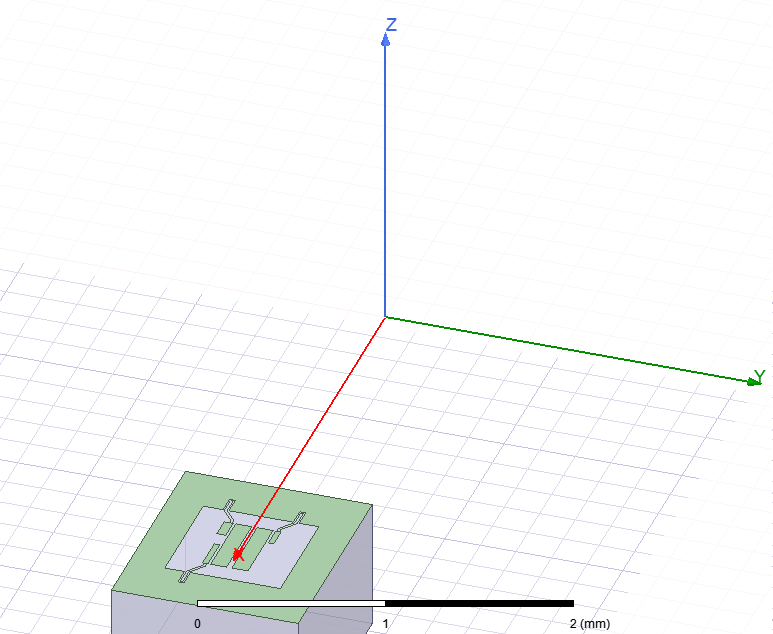

In [16]:
fourq_q3d.save_screenshot()

In [17]:
fourq_q3d.disconnect_ansys()

In [18]:
gui.main_window.close()

True